In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from selectinf.base import selected_targets
from selectinf.base import restricted_estimator
import regreg.api as rr
import scipy.stats
from scipy.stats import norm as ndist

from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)

/Users/yilingh/Desktop/PhD/SI_Codes/G_LASSO_Final/PoSI-GroupLASSO/env3/lib/python3.10/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')


# Data Cleaning

In [2]:
data_raw = pd.read_csv("data_groups_dummy_encoded.csv")

In [3]:
data_raw

,SEQN,depressed,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,...,RIAGENDR_man,DMDBORN4_US,ALQ111_dummy,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion
0,109273,1,36,0.83,21.9,2,0,7,0,0,...,1,1,1,0,0,0,1,0,0,0
1,109274,0,68,1.20,30.2,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
2,109282,0,76,3.61,26.6,1,1,8,0,0,...,1,1,1,0,1,1,1,0,1,0
3,109292,0,58,1.60,30.5,2,10,3,0,1,...,1,1,1,0,1,1,0,1,0,0
4,109293,0,44,0.02,30.1,3,7,0,0,0,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,124814,0,64,2.00,37.5,3,1,2,0,0,...,1,1,1,0,0,0,1,0,0,0
5981,124815,0,52,5.00,29.5,1,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0
5982,124817,0,67,2.19,37.9,4,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5983,124818,0,40,3.82,38.2,4,5,0,0,0,...,1,1,1,0,0,0,0,0,0,0


In [4]:
DBQ197 = data_raw[["DBQ197_never","DBQ197_often",
        "DBQ197_rarely", "DBQ197_sometimes"]].to_numpy()

In [5]:
(data_raw["ALQ111_dummy"] != 1).sum()

0

In [6]:
data_X = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy")

In [7]:
data_X.columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [8]:
data_X = data_X.to_numpy()

In [9]:
np.linalg.matrix_rank(data_X)

47

In [10]:
data_X.shape

(5985, 47)

In [11]:
design_X = np.zeros((5985,48))
design_X[:,0] = np.ones((5985,))
design_X[:,1:48] = data_X

In [12]:
np.linalg.matrix_rank(design_X)

48

In [13]:
design_X.shape

(5985, 48)

In [14]:
design_X

array([[ 1.  , 36.  ,  0.83, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 68.  ,  1.2 , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 76.  ,  3.61, ...,  0.  ,  1.  ,  0.  ],
       ...,
       [ 1.  , 67.  ,  2.19, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 40.  ,  3.82, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 63.  ,  3.71, ...,  1.  ,  0.  ,  0.  ]])

# Construct Groups

In [15]:
data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [16]:
groups = np.zeros((48,))
groups[0] = int(0) # Intercept
# Singletons
for i in range(1,7):
    groups[i] = int(i)
# RIDRETH1
groups[7:11] = int(7)
# DMDEDUC2
groups[11:15] = int(8)
# DMDMARTZ
groups[15:17] = int(9)
# INDFMMPC
groups[17:19] = int(10)
# ALQ121
groups[19:29] = int(11)
# DBQ700
groups[29:33] = int(12)
# DBQ197
groups[33:37] = int(13)
# DIQ010
groups[37:39] = int(14)
# Singletons
for i in range(39,48):
    groups[i] = int(i-24)

groups = groups.astype(int)

In [17]:
def calc_avg_group_size(groups):
    sizes = []
    for g in range(np.max(groups)+1):
        g_flag = (groups == g)
        sizes.append(g_flag.sum())

    return sizes, np.mean(sizes)

In [18]:
sizes, avg_sizes = calc_avg_group_size(groups)

In [19]:
col_names = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns.values.tolist()
col_names = ['Intercept'] + col_names

In [20]:
# Sanity check for groupings
pd.DataFrame([groups,col_names])

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,1,2,3,4,5,6,7,7,7,...,14,15,16,17,18,19,20,21,22,23
1,Intercept,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,RIDRETH1_Non_Hispanic_White,...,DIQ010_diabetes_borderline,RIAGENDR_man,DMDBORN4_US,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion


In [21]:
n,p = design_X.shape
scaling_cts = np.ones((p,))
scaling_cts[1:7] = design_X.std(0)[1:7]
cts_logical = np.zeros((p,))
cts_logical[1:7] = 1.

In [22]:
print(np.linalg.matrix_rank(design_X))
scaling = design_X.std(0) * np.sqrt(n)
scaling[0] = np.sqrt(n)
scaling[7:p] = np.sqrt(n)

X_standardized = design_X - (cts_logical * design_X.mean(axis = 0))
print(np.linalg.matrix_rank(X_standardized))
X_standardized = X_standardized / scaling[None, :]
print(np.linalg.matrix_rank(X_standardized))

48
48
48


In [23]:
X_standardized[10:18,45:50]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.01292611, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

 # Results

In [24]:
np.random.seed(48105)

## Fixing 'weight_frac' = 1

In [25]:
def plot_single_confidence_interval(x, point_est, interval,
                                    color='#2187bb', horizontal_line_width=0.25):

    left = x - horizontal_line_width / 2
    top = interval[0]
    right = x + horizontal_line_width / 2
    bottom = interval[1]
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, point_est, 'o', color='#f44336')

def plot_full_CIs(point_ests, intervals, col_names, nonzero, title):
    plt.figure(figsize=(10,6))
    col_names = np.array(col_names)
    E_card = len(col_names[nonzero])
    selected_col_names = col_names[nonzero]
    plt.xticks(list(range(1, E_card+1)), selected_col_names,
               rotation=360-45, ha='left')
    plt.title(title)
    for j in range(E_card):
        plot_single_confidence_interval(j+1, point_est=point_ests[j],
                                        interval=intervals[j])
    plt.show()


In [26]:
def group_p_val(groups, nonzero, info_inv, MLE, colnames):
    nonzero_idx = np.unique(groups[nonzero])

    MLE_full = np.zeros((nonzero.shape[0],))
    info_inv_full = np.zeros((nonzero.shape[0], nonzero.shape[0]))
    info_full = np.zeros((nonzero.shape[0], nonzero.shape[0]))

    MLE_full[nonzero] = MLE
    info_inv_full[np.ix_(nonzero,nonzero)] = info_inv
    info = np.linalg.inv(info_inv)
    info_full[np.ix_(nonzero,nonzero)] = info

    p_vals = {}

    for g in nonzero_idx:
        g_idx = groups == g
        MLE_g = MLE_full[g_idx]

        info_g = info_full[g_idx][:,g_idx]
        info_inv_g = info_inv_full[g_idx][:,g_idx]

        df_g = g_idx.sum()

        if df_g == 1:
            pivot = (MLE_g**2 / info_inv_g)[0][0]

        else:
            pivot = MLE_g.T @ info_g @ MLE_g

        p_val = scipy.stats.chi2.sf(x=pivot,df=df_g)

        print("Group Index:", g)
        print("Variables:", np.asarray(col_names)[g_idx])
        print("P-Value:", p_val)
        p_vals[g] = (p_val)

    return p_vals

In [27]:
Y = data_raw["depressed"]

In [28]:
def split_inference(X, Y, n, p, groups, group_sizes,
                    weight_frac=1. / np.sqrt(avg_sizes),
                    proportion=0.67):
    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    # Solve the split lasso objective
    conv = split_group_lasso.logistic(X=X,
                                      successes=Y,
                                      trials=np.ones(n),
                                      groups=groups,
                                      weights=weights,
                                      useJacobian=True,
                                      proportion=proportion)
    signs, soln = conv.fit()
    nonzero = signs != 0

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result, FInfo = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)
    MLestimates = result['MLE']
    pval = result['pvalue']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])

    group_pvals = group_p_val(groups, nonzero, FInfo, MLestimates, col_names)

    return MLestimates, intervals, pval, nonzero, group_pvals

In [29]:
np.random.seed(48105)
MLestimates, intervals, pval, nonzero, group_pvals = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        group_sizes=sizes,
                                                        weight_frac=1./np.sqrt(avg_sizes),
                                                        proportion=0.67)

Group Index: 0
Variables: ['Intercept']
P-Value: 1.4110555265849402e-219
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 5.924978819312171e-19
Group Index: 3
Variables: ['BMXBMI']
P-Value: 0.000665231709826451
Group Index: 6
Variables: ['DBD910']
P-Value: 1.652514244324775e-09
Group Index: 15
Variables: ['RIAGENDR_man']
P-Value: 6.902967523699435e-11
Group Index: 17
Variables: ['ALQ151_dummy']
P-Value: 2.3044807333795165e-13
Group Index: 18
Variables: ['BPQ020_hypertension']
P-Value: 0.00019918078961340678
Group Index: 21
Variables: ['MCQ010_asthma']
P-Value: 7.252580280952205e-05


In [30]:
MLestimates

0   -201.512249
1    -34.453590
2     11.627510
3     16.434367
4    -49.116400
5     70.003718
6     32.409886
7     36.977773
Name: MLE, dtype: float64

In [31]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval))

[0.     0.     0.0007 0.     0.     0.     0.0002 0.0001]


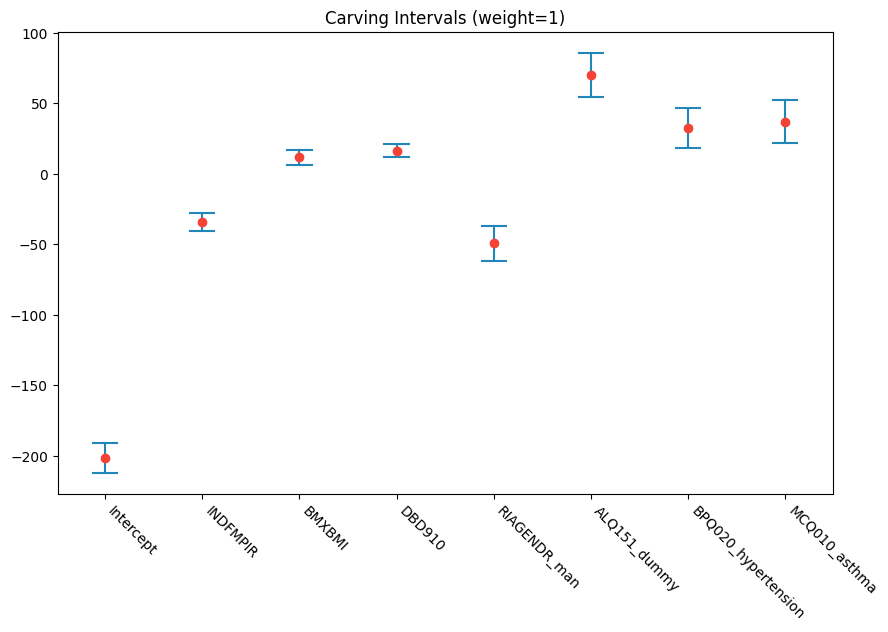

In [32]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=1)")

In [34]:
def randomized_inference(X, Y, n, p, groups, group_sizes,
                         weight_frac=1. / np.sqrt(avg_sizes),
                         proportion=0.67,
                         randomizer_scale=None):
    hess = None
    if randomizer_scale is None:
        # Estimate randomizer covariance if not using isotropic randomization
        def estimate_hess():
            loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
            # For LASSO, this is the OLS solution on X_{E,U}
            beta_full = restricted_estimator(loglike, np.array([True] * p))
            def pi_hess(x):
                return np.exp(x) / (1 + np.exp(x)) ** 2

            # Calculation the asymptotic covariance of the MLE
            W = np.diag(pi_hess(X @ beta_full))

            return X.T @ W @ X * (1 - proportion) / proportion
        hess = estimate_hess()

    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    if hess is not None:
        # Estimated randomization covariance
        print("Estimated hessian used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                cov_rand = hess)
    else:
        # Isotropic
        print("Isotropic randomization used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                randomizer_scale=randomizer_scale * sigma_)
    signs, soln = conv.fit()
    nonzero = signs != 0

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result,FInfo = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)

    pval = result['pvalue']
    MLestimates = result['MLE']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])

    group_pvals = group_p_val(groups, nonzero, FInfo, MLestimates, col_names)

    return MLestimates, intervals, pval, nonzero, group_pvals

In [35]:
np.random.seed(48105)
MLestimates_r, intervals_r, pval_r, nonzero_r, group_pvals_r = \
    randomized_inference(X=X_standardized, Y=Y, n=n, p=p,
                         groups=groups, group_sizes=sizes,
                         weight_frac=1. / np.sqrt(avg_sizes), proportion=0.9)

Estimated hessian used.
Group Index: 0
Variables: ['Intercept']
P-Value: 1.847441254096999e-82
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 3.6810622788689894e-19
Group Index: 3
Variables: ['BMXBMI']
P-Value: 0.312750963103066
Group Index: 6
Variables: ['DBD910']
P-Value: 9.628075555075993e-11
Group Index: 15
Variables: ['RIAGENDR_man']
P-Value: 0.24681420447552158
Group Index: 17
Variables: ['ALQ151_dummy']
P-Value: 0.4934288633623828
Group Index: 18
Variables: ['BPQ020_hypertension']
P-Value: 0.0026465351138474464
Group Index: 20
Variables: ['SMQ020_smoke']
P-Value: 0.9683822041460971
Group Index: 21
Variables: ['MCQ010_asthma']
P-Value: 6.491193884998407e-05


In [36]:
MLestimates_r

0   -173.622754
1    -35.540130
2     -3.695403
3     17.965755
4     -9.114184
5      6.666251
6     25.132749
7     -0.412843
8    129.824655
Name: MLE, dtype: float64

In [37]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_r))

[0.     0.     0.3128 0.     0.2468 0.4934 0.0026 0.9684 0.0001]


In [38]:
nonzero_r.sum()

9

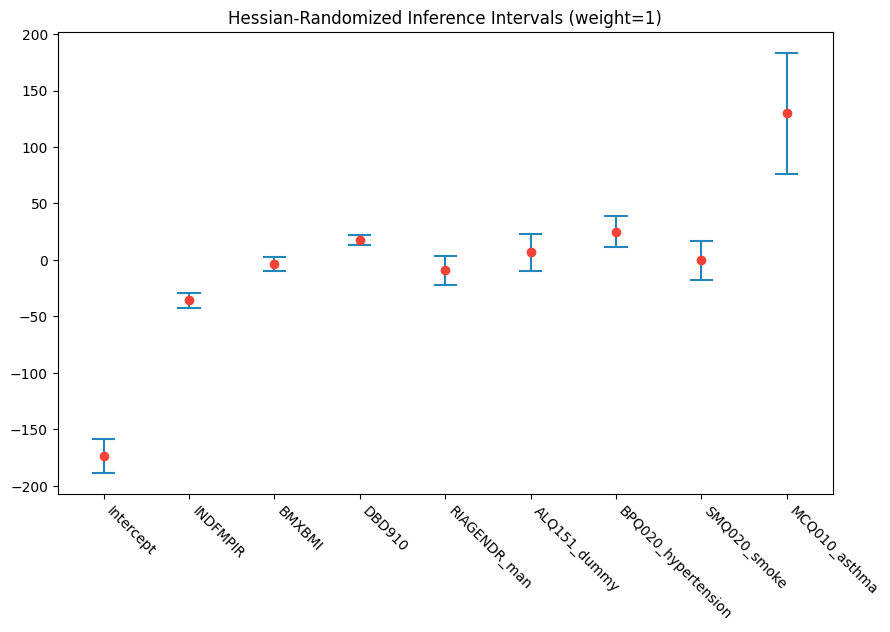

In [39]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=1)")

In [41]:
np.random.seed(48105)
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso, group_pvals_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         group_sizes=sizes,
                         weight_frac=1/np.sqrt(avg_sizes),
                         randomizer_scale=1)

Isotropic randomization used.
Group Index: 0
Variables: ['Intercept']
P-Value: 3.027590613430375e-192
Group Index: 1
Variables: ['RIDAGEYR']
P-Value: 0.01666894533132075
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 1.3051463670591908e-16
Group Index: 3
Variables: ['BMXBMI']
P-Value: 0.007153015880796596
Group Index: 4
Variables: ['DBD895']
P-Value: 0.3006524697710884
Group Index: 6
Variables: ['DBD910']
P-Value: 1.7720357298123308e-12
Group Index: 14
Variables: ['DIQ010_diabetes' 'DIQ010_diabetes_borderline']
P-Value: 0.031830007746634956
Group Index: 15
Variables: ['RIAGENDR_man']
P-Value: 8.915104238431325e-13
Group Index: 17
Variables: ['ALQ151_dummy']
P-Value: 1.618920222697418e-10
Group Index: 18
Variables: ['BPQ020_hypertension']
P-Value: 8.721197655012102e-06
Group Index: 20
Variables: ['SMQ020_smoke']
P-Value: 0.004314869881564268


In [42]:
MLestimates_iso

0    -207.390014
1     -10.871142
2     -33.759870
3       9.348437
4       5.314801
5      20.945651
6      22.058335
7       2.582188
8     -55.328644
9      57.330700
10     37.616594
11     22.200249
Name: MLE, dtype: float64

In [43]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_iso))

[0.     0.0167 0.     0.0072 0.3007 0.     0.0304 0.9167 0.     0.
 0.     0.0043]


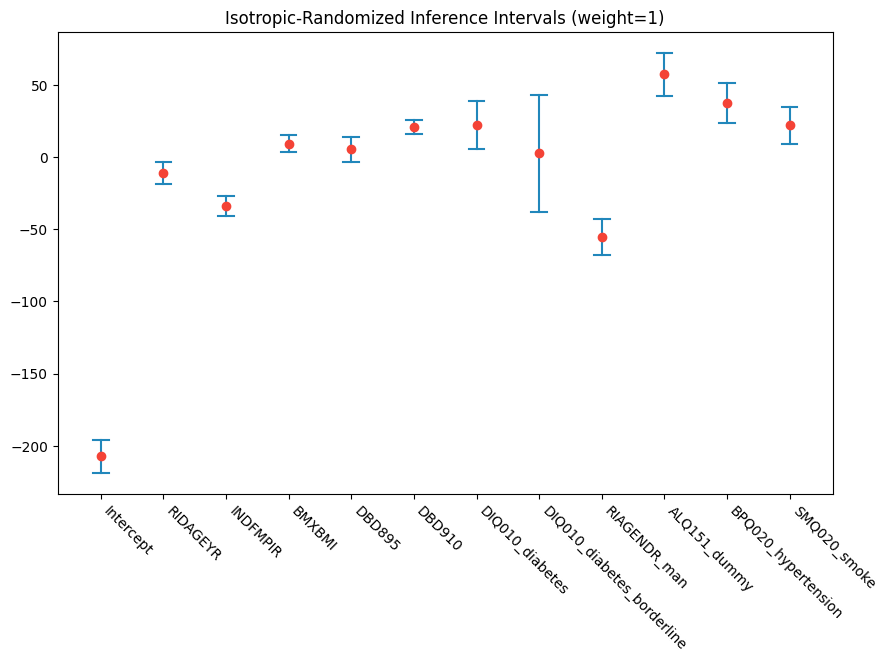

In [44]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=1)")

In [46]:
def data_splitting(X, Y, n, p, groups, group_sizes, weight_frac=1. / np.sqrt(avg_sizes),
                   proportion=0.67, level=0.9):

    pi_s = proportion
    subset_select = np.zeros(n, np.bool)
    subset_select[:int(pi_s * n)] = True
    n1 = subset_select.sum()
    n2 = n - n1
    np.random.shuffle(subset_select)
    X_S = X[subset_select, :]
    Y_S = Y[subset_select]

    # Selection on the first subset of data
    p = X.shape[1]
    sigma_ = np.std(Y_S)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict([(i, (n1/n) * weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X_S,
                                successes=Y_S,
                                trials=np.ones(n1),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    n1 = subset_select.sum()
    n2 = n - n1

    if nonzero.sum() > 0:
        X_notS = X[~subset_select, :]
        Y_notS = Y[~subset_select]

        # E: nonzero flag

        X_notS_E = X_notS[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X_notS, successes=Y_notS, trials=np.ones(n2))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE_notS = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_notS_E @ beta_MLE_notS))

        f_info = X_notS_E.T @ W @ X_notS_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE_notS + z_low * sd
        intervals_up = beta_MLE_notS + z_up * sd
        intervals = np.asarray([intervals_low,intervals_up]).T

        # p-values
        Z_scores = beta_MLE_notS / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        group_pvals = group_p_val(groups, nonzero, cov, beta_MLE_notS, col_names)

        return beta_MLE_notS, intervals, pvalues, nonzero, group_pvals

    # If no variable selected, no inference
    return None, None, None, None, None

In [47]:
np.random.seed(48105)
MLestimates_ds, intervals_ds, pval_ds, nonzero_ds, group_pvals_ds\
    = data_splitting(X=X_standardized, Y=Y, n=n, p=p, groups=groups,
                     group_sizes=sizes, weight_frac=1. / np.sqrt(avg_sizes),
                     proportion=0.9)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_88421/1881621092.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  subset_select = np.zeros(n, np.bool)


Group Index: 0
Variables: ['Intercept']
P-Value: 3.0944575359142386e-11
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 0.002315232595556175
Group Index: 3
Variables: ['BMXBMI']
P-Value: 0.001751329582381997
Group Index: 6
Variables: ['DBD910']
P-Value: 0.35725282509958645
Group Index: 9
Variables: ['DMDMARTZ_married_living_with' 'DMDMARTZ_sep']
P-Value: 0.0001485090755741522
Group Index: 15
Variables: ['RIAGENDR_man']
P-Value: 0.031972115412984906
Group Index: 17
Variables: ['ALQ151_dummy']
P-Value: 0.0033362735281581013


In [48]:
MLestimates_ds

array([-243.2228,  -44.6158,   31.2321,   10.2163,   48.4884,   63.4248,
        -57.6775,   85.9029])

In [49]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_ds))

[0.     0.0023 0.0018 0.3573 0.1922 0.1015 0.032  0.0033]


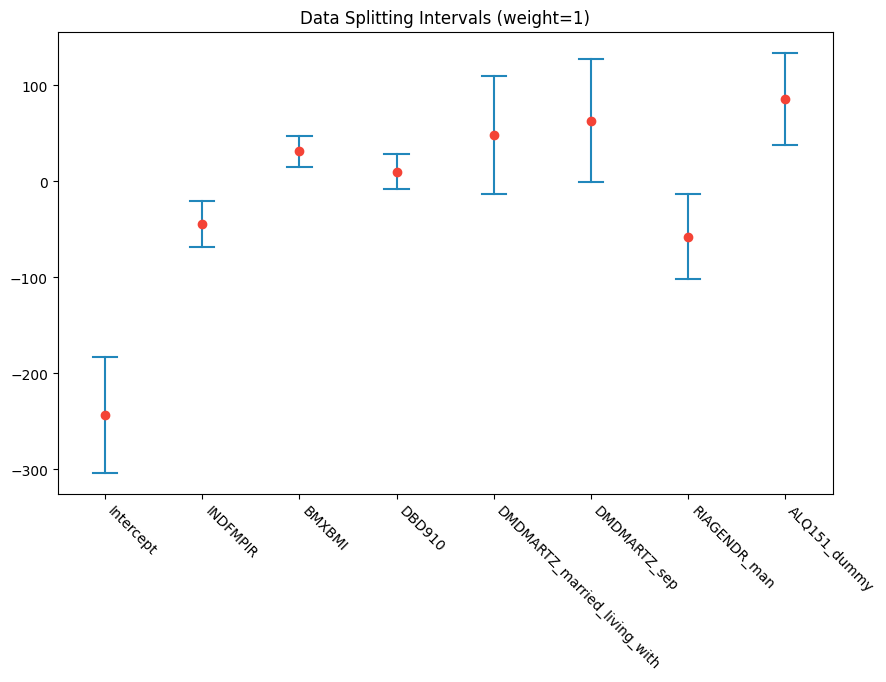

In [50]:
plot_full_CIs(MLestimates_ds, intervals_ds, col_names, nonzero_ds,
              "Data Splitting Intervals (weight=1)")

In [52]:
def naive_inference(X, Y, n, p, groups, group_sizes,
                    weight_frac=1./np.sqrt(avg_sizes),
                    level=0.9):

    # Selection
    p = X.shape[1]
    sigma_ = np.std(Y)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict([(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    if nonzero.sum() > 0:

        # E: nonzero flag
        X_E = X[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_E @ beta_MLE))

        f_info = X_E.T @ W @ X_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE + z_low * sd
        intervals_up = beta_MLE + z_up * sd
        intervals = np.asarray([intervals_low,intervals_up]).T

        # p-values
        Z_scores = beta_MLE / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        group_pvals = group_p_val(groups, nonzero, cov, beta_MLE, col_names)

        return beta_MLE, intervals, pvalues, nonzero, group_pvals

    # If no variable selected, no inference
    return None, None, None, None, None

In [53]:
np.random.seed(48105)
MLestimates_naive, intervals_naive, pval_naive, nonzero_naive, group_pvals_naive = \
    naive_inference(X=X_standardized, Y=Y, n=n, p=p,
                    groups=groups,group_sizes=sizes,
                    weight_frac=1. / np.sqrt(avg_sizes))

Group Index: 0
Variables: ['Intercept']
P-Value: 6.028193037904483e-92
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 3.98383538649357e-15
Group Index: 3
Variables: ['BMXBMI']
P-Value: 1.5170059872446985e-05
Group Index: 6
Variables: ['DBD910']
P-Value: 2.4135802208948256e-08
Group Index: 9
Variables: ['DMDMARTZ_married_living_with' 'DMDMARTZ_sep']
P-Value: 0.00018048048440095436
Group Index: 15
Variables: ['RIAGENDR_man']
P-Value: 2.584079083524612e-10
Group Index: 17
Variables: ['ALQ151_dummy']
P-Value: 4.417800286225839e-16


In [54]:
MLestimates_naive

array([-172.5244,  -32.4466,   13.682 ,   14.7719,  -20.9205,    8.1478,
        -49.6876,   71.0628])

In [55]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_naive))

[0.     0.     0.     0.     0.0253 0.4133 0.     0.    ]


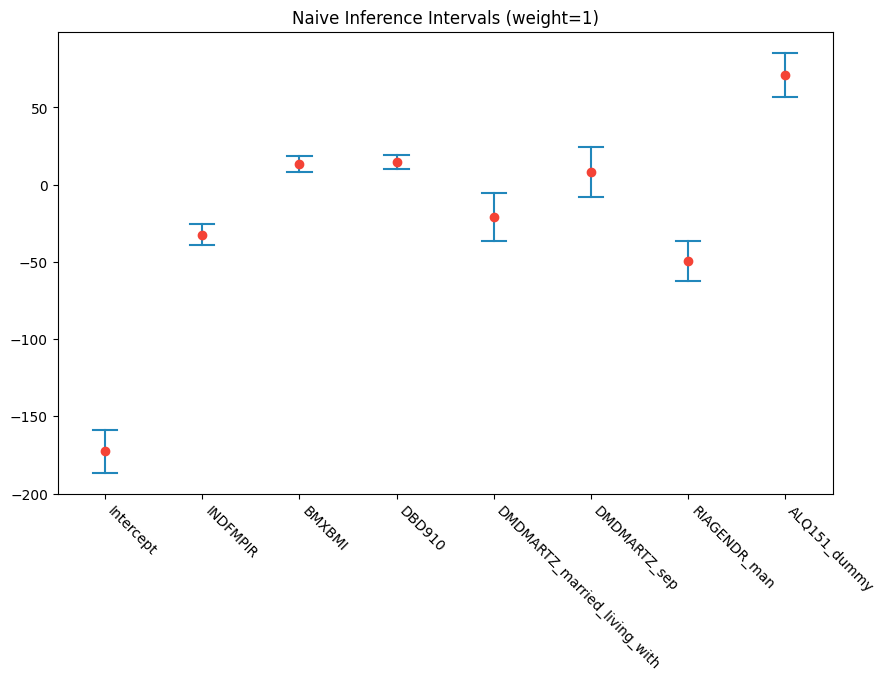

In [56]:
plot_full_CIs(MLestimates_naive, intervals_naive, col_names, nonzero_naive,
              "Naive Inference Intervals (weight=1)")

### Comparing outputs of different methods

In [57]:
def tabulate_results(nonzero_list,intervals_list,groups=groups,colnames=col_names,
                     path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            for k in range(len(nonzero_list)):
                if nonzero_list[k][j]:
                    selected = True
            # Include this into the summary if selected
            if selected:
                row = []
                for l in range(len(nonzero_list)):
                    if nonzero_list[l][j]:
                        idx_among_selected = np.sum(nonzero_list[l][0:j])
                        interval_l = intervals_list[l][idx_among_selected,0]
                        interval_u = intervals_list[l][idx_among_selected,1]
                        row.append("(" + str(round(interval_l,3)) + ","
                                   + str(round(interval_u,3)) + ")")
                    else:
                        row.append("-")
                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    avg_len = []
    for k in range(len(nonzero_list)):
        interval_l = intervals_list[k][:,0]
        interval_u = intervals_list[k][:,1]
        avg_len.append(np.mean(interval_u - interval_l))
    row_df = pd.DataFrame(avg_len).T
    output_df = pd.concat([output_df, row_df], axis=0)
    selected_varnames.append("Avg. CI Length")

    output_df.index = selected_varnames
    if path is not None:
        output_df.to_csv(path)

    return output_df


In [59]:
def tabulate_results_separate(nonzero_list,intervals_list,
                              p_values_list,group_pvalues_list,
                              groups=groups, colnames=col_names, path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            for k in range(len(nonzero_list)):
                if nonzero_list[k][j]:
                    selected = True
            # Include this into the summary if selected
            if selected:
                row = []

                row.append(i) # Record group index
                # iterate over all methods
                for l in range(len(nonzero_list)):
                    if nonzero_list[l][j]:
                        idx_among_selected = np.sum(nonzero_list[l][0:j])
                        interval_l = intervals_list[l][idx_among_selected,0]
                        interval_u = intervals_list[l][idx_among_selected,1]
                        row.append(interval_l)
                        row.append(interval_u)
                        row.append(p_values_list[l][idx_among_selected])
                        row.append(group_pvalues_list[l][i])
                    else:
                        row.append(0)
                        row.append(0)
                        row.append(1.)
                        row.append(1.)

                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    """
    avg_len = []
    for k in range(len(nonzero_list)):
        interval_l = intervals_list[k][:,0]
        interval_u = intervals_list[k][:,1]
        avg_len.append(np.mean(interval_u - interval_l))
    row_df = pd.DataFrame(avg_len).T
    output_df = pd.concat([output_df, row_df], axis=0)
    selected_varnames.append("Avg. CI Length")
    """

    output_df.index = selected_varnames
    if path is not None:
        output_df.to_csv(path)

    return output_df

In [60]:
def tabulate_one_method(nonzero,intervals,estimates,p_values,groups=groups,
                        colnames=col_names, path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            if nonzero[j]:
                selected = True
            # Include this into the summary if selected
            if selected:
                row = []
                if nonzero[j]:
                    idx_among_selected = np.sum(nonzero[0:j])
                    interval_l = intervals[idx_among_selected,0]
                    interval_u = intervals[idx_among_selected,1]
                    row.append(interval_l)
                    row.append(interval_u)
                    row.append(estimates[idx_among_selected])
                    row.append(p_values[idx_among_selected])
                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    output_df.index = selected_varnames
    output_df.columns = ["Lower", "Upper", "MLE", "P value"]
    if path is not None:
        output_df.to_csv(path)

    return output_df

In [61]:
nonzero_list = [nonzero_naive, nonzero_ds, nonzero_r]
intervals_list = [intervals_naive, intervals_ds, intervals_r]
output_comparison = tabulate_results(nonzero_list=nonzero_list,
                                     intervals_list=intervals_list)

In [62]:
output_comparison.columns = ["Naive", "Data splitting", "Hessian Randomized"]

In [63]:
output_comparison

,Naive,Data splitting,Hessian Randomized
Intercept,"(-186.478,-158.571)","(-303.455,-182.99)","(-188.469,-158.776)"
INDFMPIR,"(-39.241,-25.653)","(-68.705,-20.527)","(-42.075,-29.006)"
BMXBMI,"(8.48,18.884)","(14.816,47.648)","(-9.717,2.326)"
DBD910,"(10.417,19.127)","(-8.037,28.47)","(13.4,22.531)"
DMDMARTZ_married_living_with,"(-36.3,-5.541)","(-12.665,109.642)",-
DMDMARTZ_sep,"(-8.233,24.528)","(-0.279,127.128)",-
RIAGENDR_man,"(-62.616,-36.76)","(-101.911,-13.444)","(-22.059,3.83)"
ALQ151_dummy,"(56.679,85.446)","(37.759,134.046)","(-9.344,22.677)"
BPQ020_hypertension,-,-,"(11.381,38.885)"
SMQ020_smoke,-,-,"(-17.545,16.719)"


In [64]:
pvalues_list = [pval_naive, pval_ds, pval_r]
group_pvals_list = [group_pvals_naive, group_pvals_ds, group_pvals_r]
output_separated = tabulate_results_separate(nonzero_list=nonzero_list,
                                             intervals_list=intervals_list,
                                             p_values_list=pvalues_list,
                                             group_pvalues_list=group_pvals_list)

In [65]:
output_separated.columns = ["Group Index",
                            "N_L", "N_U", "N_pval", "N_grouppval", # Naive
                            "DS_L", "DS_U", "DS_pval", "DS_grouppval", # DS
                            "HR_L", "HR_U", "HR_pval", "HR_grouppval", # Hessian-randomized
                            ]

In [66]:
output_separated

,Group Index,N_L,N_U,N_pval,N_grouppval,DS_L,DS_U,DS_pval,DS_grouppval,HR_L,HR_U,HR_pval,HR_grouppval
Intercept,0.0,-186.478033,-158.570800,6.028193e-92,6.028193e-92,-303.455448,-182.990057,3.094458e-11,3.094458e-11,-188.469042,-158.776466,1.847441e-82,1.847441e-82
INDFMPIR,2.0,-39.240570,-25.652565,3.983835e-15,3.983835e-15,-68.704541,-20.527001,2.315233e-03,2.315233e-03,-42.074598,-29.005662,3.681062e-19,3.681062e-19
BMXBMI,3.0,8.480005,18.883990,1.517006e-05,1.517006e-05,14.816353,47.647777,1.751330e-03,1.751330e-03,-9.716799,2.325993,3.127510e-01,3.127510e-01
DBD910,6.0,10.416985,19.126727,2.413580e-08,2.413580e-08,-8.037145,28.469826,3.572528e-01,3.572528e-01,13.400251,22.531259,9.628076e-11,9.628076e-11
DMDMARTZ_married_living_with,9.0,-36.299978,-5.540977,2.525584e-02,1.804805e-04,-12.664898,109.641722,1.921643e-01,1.485091e-04,0.000000,0.000000,1.000000e+00,1.000000e+00
DMDMARTZ_sep,9.0,-8.232788,24.528487,4.132645e-01,1.804805e-04,-0.278882,127.128389,1.014941e-01,1.485091e-04,0.000000,0.000000,1.000000e+00,1.000000e+00
RIAGENDR_man,15.0,-62.615536,-36.759657,2.584079e-10,2.584079e-10,-101.911319,-13.443596,3.197212e-02,3.197212e-02,-22.058846,3.830478,2.468142e-01,2.468142e-01
ALQ151_dummy,17.0,56.679307,85.446330,4.440892e-16,4.417800e-16,37.759355,134.046383,3.336274e-03,3.336274e-03,-9.344205,22.676708,4.934289e-01,4.934289e-01
BPQ020_hypertension,18.0,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,1.000000e+00,1.000000e+00,11.380648,38.884851,2.646535e-03,2.646535e-03
SMQ020_smoke,20.0,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,1.000000e+00,1.000000e+00,-17.544786,16.719100,9.683822e-01,9.683822e-01


In [67]:
output_separated.to_csv("weight1.csv")

In [68]:
output_ds_1 = tabulate_one_method(nonzero=nonzero_ds,
                                  intervals=intervals_ds,
                                  estimates=MLestimates_ds,
                                  p_values=pval_ds,
                                  path="weight1_ds.csv")
output_naive_1 = tabulate_one_method(nonzero=nonzero_naive,
                                  intervals=intervals_naive,
                                  estimates=MLestimates_naive,
                                  p_values=pval_naive,
                                  path="weight1_naive.csv")
output_random_1 = tabulate_one_method(nonzero=nonzero_r,
                                  intervals=intervals_r,
                                  estimates=MLestimates_r,
                                  p_values=pval_r,
                                  path="weight1_r.csv")

## Results with other values of 'weight_frac'

### weight_frac = 0.5

In [69]:
np.random.seed(48105)
MLestimates, intervals, pval, nonzero, group_pvals = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        group_sizes=sizes,
                                                        weight_frac=0.5/np.sqrt(avg_sizes),
                                                        proportion=0.9)

Group Index: 0
Variables: ['Intercept']
P-Value: 0.48714525218976046
Group Index: 1
Variables: ['RIDAGEYR']
P-Value: 0.08380422314014362
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 1.0021368764374492e-07
Group Index: 3
Variables: ['BMXBMI']
P-Value: 2.684487055130921e-05
Group Index: 4
Variables: ['DBD895']
P-Value: 0.9394524993130924
Group Index: 5
Variables: ['DBD905']
P-Value: 0.5588956751634352
Group Index: 6
Variables: ['DBD910']
P-Value: 0.03150697476029114
Group Index: 9
Variables: ['DMDMARTZ_married_living_with' 'DMDMARTZ_sep']
P-Value: 3.064512159809226e-25
Group Index: 12
Variables: ['DBQ700_1' 'DBQ700_2' 'DBQ700_3' 'DBQ700_4']
P-Value: 0.0
Group Index: 15
Variables: ['RIAGENDR_man']
P-Value: 8.121995509282481e-07
Group Index: 17
Variables: ['ALQ151_dummy']
P-Value: 9.093556630677518e-09
Group Index: 18
Variables: ['BPQ020_hypertension']
P-Value: 2.060647198047918e-09
Group Index: 19
Variables: ['BPQ080_high_cholesterol']
P-Value: 0.3961944699592411
Group Index: 20
Variab

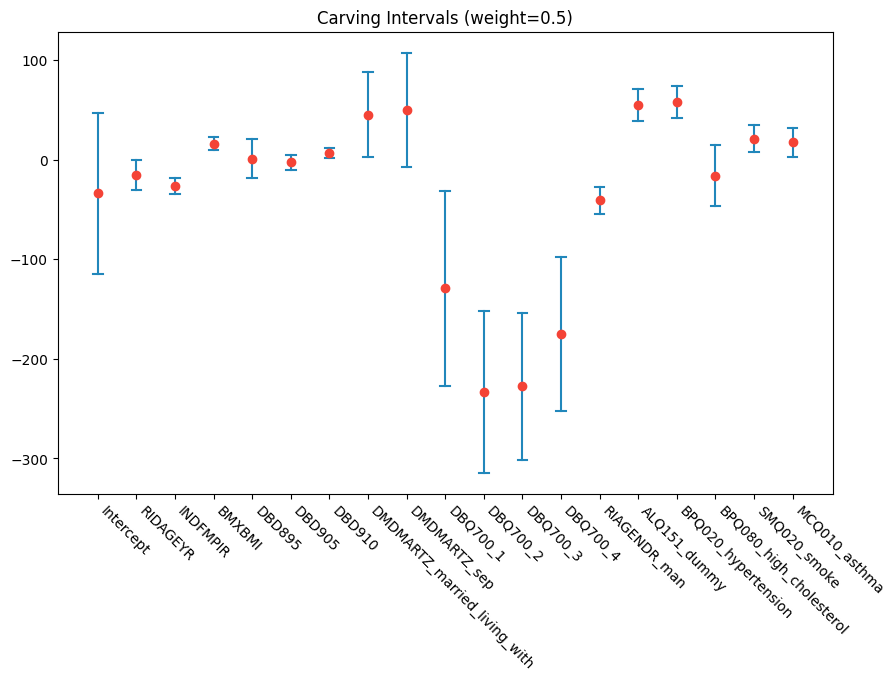

In [70]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=0.5)")

In [71]:
np.random.seed(48105)
MLestimates_r, intervals_r, pval_r, nonzero_r, group_pvals_r = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         group_sizes=sizes,
                         weight_frac=0.5 / np.sqrt(avg_sizes),
                         proportion=0.9)

Estimated hessian used.
Group Index: 0
Variables: ['Intercept']
P-Value: 0.5999672054754339
Group Index: 1
Variables: ['RIDAGEYR']
P-Value: 0.3266717909955039
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 5.327789012016267e-09
Group Index: 3
Variables: ['BMXBMI']
P-Value: 0.6158302401461615
Group Index: 4
Variables: ['DBD895']
P-Value: 0.22297839343885714
Group Index: 5
Variables: ['DBD905']
P-Value: 0.1664773705289303
Group Index: 6
Variables: ['DBD910']
P-Value: 3.8108135417388203e-11
Group Index: 7
Variables: ['RIDRETH1_Mexican_American' 'RIDRETH1_Other_Hispanic'
 'RIDRETH1_Non_Hispanic_White' 'RIDRETH1_Non_Hispanic_Black']
P-Value: 1.5493041306847547e-31
Group Index: 9
Variables: ['DMDMARTZ_married_living_with' 'DMDMARTZ_sep']
P-Value: 8.293913951835713e-18
Group Index: 12
Variables: ['DBQ700_1' 'DBQ700_2' 'DBQ700_3' 'DBQ700_4']
P-Value: 3.2132501792485907e-285
Group Index: 15
Variables: ['RIAGENDR_man']
P-Value: 0.8216644234083409
Group Index: 17
Variables: ['ALQ151_dummy']
P-Va

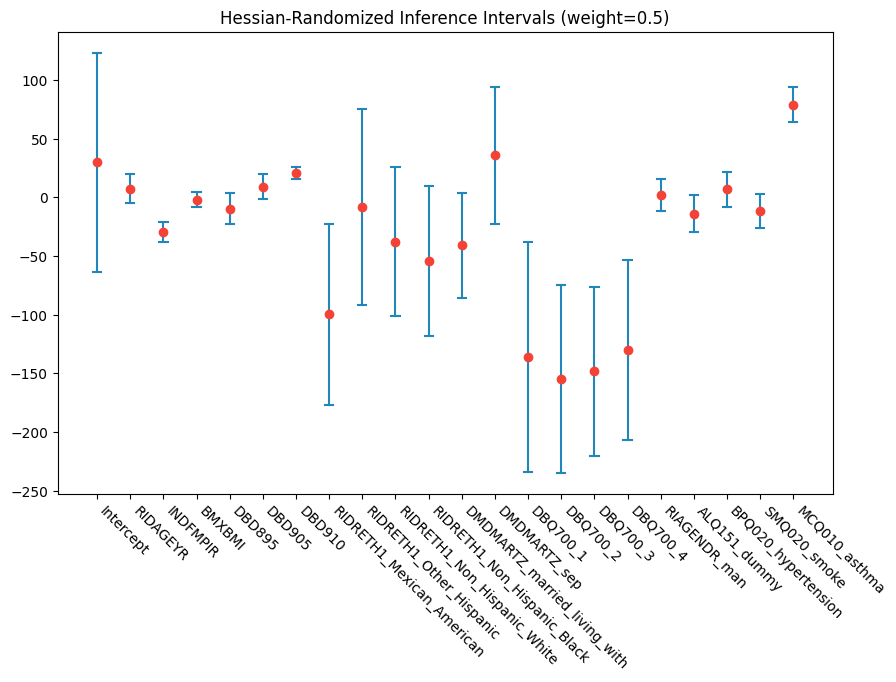

In [72]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=0.5)")

In [73]:
np.random.seed(48105)
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso, group_pvals_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         group_sizes=sizes,
                         weight_frac=0.5 / np.sqrt(avg_sizes),
                         randomizer_scale=1)

Isotropic randomization used.
Group Index: 0
Variables: ['Intercept']
P-Value: 3.812145196698564e-08
Group Index: 1
Variables: ['RIDAGEYR']
P-Value: 0.1408620187394309
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 6.355025725407025e-10
Group Index: 3
Variables: ['BMXBMI']
P-Value: 0.19788341509578158
Group Index: 4
Variables: ['DBD895']
P-Value: 0.7377355515824819
Group Index: 5
Variables: ['DBD905']
P-Value: 0.15341080616288735
Group Index: 6
Variables: ['DBD910']
P-Value: 5.060723793268043e-07
Group Index: 7
Variables: ['RIDRETH1_Mexican_American' 'RIDRETH1_Other_Hispanic'
 'RIDRETH1_Non_Hispanic_White' 'RIDRETH1_Non_Hispanic_Black']
P-Value: 3.9747610876682534e-10
Group Index: 8
Variables: ['DMDEDUC2_1' 'DMDEDUC2_2' 'DMDEDUC2_3' 'DMDEDUC2_4']
P-Value: 0.22766776389229812
Group Index: 11
Variables: ['ALQ121_0' 'ALQ121_1' 'ALQ121_2' 'ALQ121_3' 'ALQ121_4' 'ALQ121_5'
 'ALQ121_6' 'ALQ121_7' 'ALQ121_8' 'ALQ121_9']
P-Value: 2.378267224818361e-10
Group Index: 12
Variables: ['DBQ700_1' 'DB

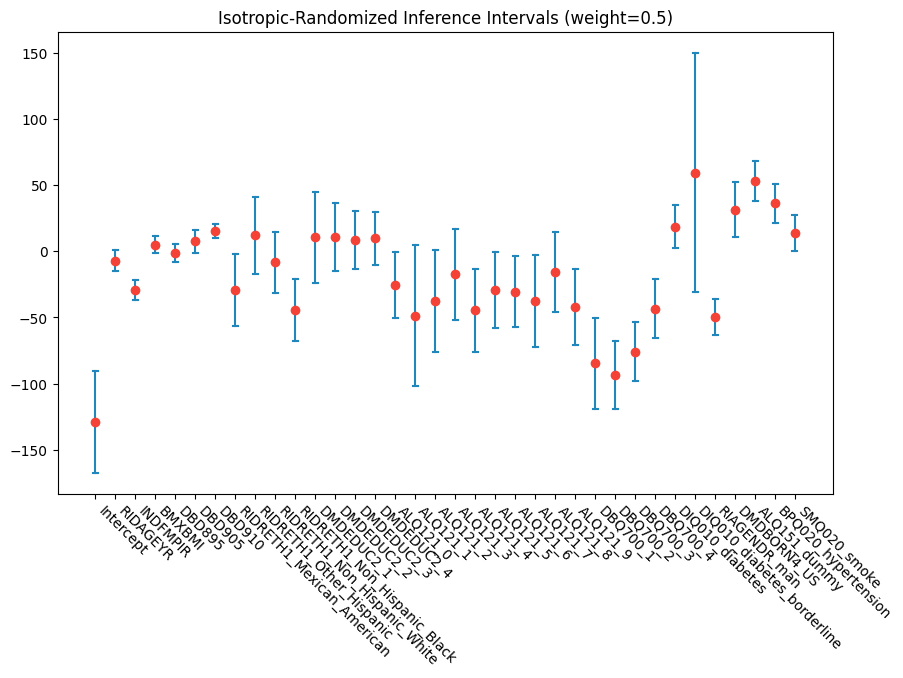

In [74]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=0.5)")

In [75]:
np.random.seed(48105)
MLestimates_ds, intervals_ds, pval_ds, nonzero_ds, group_pvals_ds\
    = data_splitting(X=X_standardized, Y=Y, n=n, p=p,
                     groups=groups, group_sizes=sizes,
                     weight_frac=0.5 / np.sqrt(avg_sizes),
                     proportion=0.9)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_88421/1881621092.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  subset_select = np.zeros(n, np.bool)


Group Index: 0
Variables: ['Intercept']
P-Value: 7.785193545752158e-05
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 0.04267335693205224
Group Index: 3
Variables: ['BMXBMI']
P-Value: 0.04312253578802439
Group Index: 5
Variables: ['DBD905']
P-Value: 0.9018750900775276
Group Index: 6
Variables: ['DBD910']
P-Value: 0.43106764656940266
Group Index: 9
Variables: ['DMDMARTZ_married_living_with' 'DMDMARTZ_sep']
P-Value: 0.00048163722589288267
Group Index: 12
Variables: ['DBQ700_1' 'DBQ700_2' 'DBQ700_3' 'DBQ700_4']
P-Value: 8.577719917963355e-10
Group Index: 15
Variables: ['RIAGENDR_man']
P-Value: 0.027568354182405733
Group Index: 17
Variables: ['ALQ151_dummy']
P-Value: 0.028072047703596663
Group Index: 18
Variables: ['BPQ020_hypertension']
P-Value: 0.026051062410554802
Group Index: 20
Variables: ['SMQ020_smoke']
P-Value: 0.6169132038091782
Group Index: 21
Variables: ['MCQ010_asthma']
P-Value: 0.5138309181519005


In [76]:
np.random.seed(48105)
MLestimates_naive, intervals_naive, pval_naive, nonzero_naive, group_pvals_naive = \
    naive_inference(X=X_standardized, Y=Y, n=n, p=p,
                    groups=groups, group_sizes=sizes, weight_frac=0.5 / np.sqrt(avg_sizes))

Group Index: 0
Variables: ['Intercept']
P-Value: 2.3337096689037352e-14
Group Index: 1
Variables: ['RIDAGEYR']
P-Value: 0.03680014509533897
Group Index: 2
Variables: ['INDFMPIR']
P-Value: 9.313841037211173e-10
Group Index: 3
Variables: ['BMXBMI']
P-Value: 0.09290040757972753
Group Index: 4
Variables: ['DBD895']
P-Value: 0.772538368726549
Group Index: 5
Variables: ['DBD905']
P-Value: 0.17059098531751626
Group Index: 6
Variables: ['DBD910']
P-Value: 0.00018071846902272226
Group Index: 7
Variables: ['RIDRETH1_Mexican_American' 'RIDRETH1_Other_Hispanic'
 'RIDRETH1_Non_Hispanic_White' 'RIDRETH1_Non_Hispanic_Black']
P-Value: 1.7626511811095247e-06
Group Index: 9
Variables: ['DMDMARTZ_married_living_with' 'DMDMARTZ_sep']
P-Value: 3.2054239975969104e-05
Group Index: 12
Variables: ['DBQ700_1' 'DBQ700_2' 'DBQ700_3' 'DBQ700_4']
P-Value: 2.6557202057470993e-62
Group Index: 15
Variables: ['RIAGENDR_man']
P-Value: 2.191972051658673e-09
Group Index: 17
Variables: ['ALQ151_dummy']
P-Value: 1.841084293

In [77]:
nonzero_list = [nonzero_naive, nonzero_ds, nonzero_r]
intervals_list = [intervals_naive, intervals_ds, intervals_r]
output_comparison = tabulate_results(nonzero_list=nonzero_list,
                                     intervals_list=intervals_list)

In [78]:
output_comparison.columns = ["Naive", "Data splitting", "Hessian Randomized"]

In [79]:
output_comparison

,Naive,Data splitting,Hessian Randomized
Intercept,"(-156.811,-101.196)","(-268.936,-110.831)","(-63.625,123.189)"
RIDAGEYR,"(-17.723,-2.104)",-,"(-5.01,19.812)"
INDFMPIR,"(-34.239,-19.734)","(-56.332,-5.861)","(-38.347,-21.485)"
BMXBMI,"(0.122,11.414)","(4.118,39.989)","(-8.461,4.505)"
DBD895,"(-7.443,5.218)",-,"(-22.89,3.407)"
DBD905,"(-0.932,10.241)","(-15.568,18.09)","(-1.685,19.532)"
DBD910,"(6.014,15.435)","(-9.608,27.254)","(15.505,25.776)"
RIDRETH1_Mexican_American,"(-43.446,8.195)",-,"(-176.805,-23.066)"
RIDRETH1_Other_Hispanic,"(-21.76,29.001)",-,"(-91.692,74.963)"
RIDRETH1_Non_Hispanic_White,"(-19.094,20.527)",-,"(-101.202,25.4)"


In [80]:
output_ds_05 = tabulate_one_method(nonzero=nonzero_ds,
                                  intervals=intervals_ds,
                                  estimates=MLestimates_ds,
                                  p_values=pval_ds,
                                  path="weight0.5_ds.csv")
output_naive_05 = tabulate_one_method(nonzero=nonzero_naive,
                                  intervals=intervals_naive,
                                  estimates=MLestimates_naive,
                                  p_values=pval_naive,
                                  path="weight0.5_naive.csv")
output_random_05 = tabulate_one_method(nonzero=nonzero_r,
                                  intervals=intervals_r,
                                  estimates=MLestimates_r,
                                  p_values=pval_r,
                                  path="weight0.5_r.csv")

In [81]:
pvalues_list = [pval_naive, pval_ds, pval_r]
group_pvals_list = [group_pvals_naive, group_pvals_ds, group_pvals_r]
output_separated = tabulate_results_separate(nonzero_list=nonzero_list,
                                             intervals_list=intervals_list,
                                             p_values_list=pvalues_list,
                                             group_pvalues_list=group_pvals_list)

In [82]:
output_separated.columns = ["Group Index",
                            "N_L", "N_U", "N_pval", "N_grouppval", # Naive
                            "DS_L", "DS_U", "DS_pval", "DS_grouppval", # DS
                            "HR_L", "HR_U", "HR_pval", "HR_grouppval", # Hessian-randomized
                            ]

In [83]:
output_separated

,Group Index,N_L,N_U,N_pval,N_grouppval,DS_L,DS_U,DS_pval,DS_grouppval,HR_L,HR_U,HR_pval,HR_grouppval
Intercept,0.0,-156.811366,-101.196350,2.333710e-14,2.333710e-14,-268.935588,-110.830614,0.000078,7.785194e-05,-63.624810,123.188727,5.999672e-01,5.999672e-01
RIDAGEYR,1.0,-17.722691,-2.103845,3.680015e-02,3.680015e-02,0.000000,0.000000,1.000000,1.000000e+00,-5.010270,19.811981,3.266718e-01,3.266718e-01
INDFMPIR,2.0,-34.238603,-19.734252,9.313841e-10,9.313841e-10,-56.331911,-5.861245,0.042673,4.267336e-02,-38.346862,-21.485164,5.327789e-09,5.327789e-09
BMXBMI,3.0,0.121648,11.413924,9.290041e-02,9.290041e-02,4.118077,39.988952,0.043123,4.312254e-02,-8.460697,4.505355,6.158302e-01,6.158302e-01
DBD895,4.0,-7.443094,5.218096,7.725384e-01,7.725384e-01,0.000000,0.000000,1.000000,1.000000e+00,-22.890390,3.407036,2.229784e-01,2.229784e-01
DBD905,5.0,-0.932457,10.240562,1.705910e-01,1.705910e-01,-15.567589,18.090492,0.901875,9.018751e-01,-1.684883,19.532127,1.664774e-01,1.664774e-01
DBD910,6.0,6.013612,15.435469,1.807185e-04,1.807185e-04,-9.608390,27.253704,0.431068,4.310676e-01,15.505242,25.775804,3.810818e-11,3.810814e-11
RIDRETH1_Mexican_American,7.0,-43.446467,8.195256,2.615244e-01,1.762651e-06,0.000000,0.000000,1.000000,1.000000e+00,-176.804635,-23.066364,3.248186e-02,1.549304e-31
RIDRETH1_Other_Hispanic,7.0,-21.760301,29.001071,8.144980e-01,1.762651e-06,0.000000,0.000000,1.000000,1.000000e+00,-91.691777,74.963342,8.688602e-01,1.549304e-31
RIDRETH1_Non_Hispanic_White,7.0,-19.094018,20.527268,9.525535e-01,1.762651e-06,0.000000,0.000000,1.000000,1.000000e+00,-101.201661,25.400192,3.247036e-01,1.549304e-31


In [84]:
output_separated.to_csv("weight0.5.csv")